In [1]:
from typing import Optional

import numpy as np
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
class DecisionTree:
    class Node:
        def __init__(
            self, left=None, right=None, feature=None, threshold=None, value=None
        ):
            self.left = left
            self.right = right
            self.value = value
            self.feature = feature
            self.threshold = threshold

        def isLeaf(self):
            return self.left is None and self.right is None

    def __init__(self, maxDepth: int = 5):
        self.maxDepth = maxDepth
        self.tree = None

    def fit(self, XTrain, yTrain):
        self.tree = self._buildTree(XTrain, yTrain)

    def _buildTree(self, XTrain, yTrain, depth=0):
        if len(yTrain) == 0:
            return None

        # If only one class or max depth reached, return leaf
        numLabels = len(np.unique(yTrain))
        if depth >= self.maxDepth or numLabels == 1:
            leafValue = self._getLeafValue(yTrain)
            return self.Node(value=leafValue)

        feature, threshold = self._findBestSplit(XTrain, yTrain)

        # If no best split found (no info gain), return leaf
        if feature is None or threshold is None:
            leafValue = self._getLeafValue(yTrain)

            return self.Node(value=leafValue)

        leftIndices, rightIndices = self._splitArray(XTrain[:, feature], threshold)

        leftXTrain, rightXTrain = XTrain[leftIndices], XTrain[rightIndices]
        leftYTrain, rightYTrain = yTrain[leftIndices], yTrain[rightIndices]

        left = self._buildTree(leftXTrain, leftYTrain, depth + 1)
        right = self._buildTree(rightXTrain, rightYTrain, depth + 1)

        return self.Node(
            left=left,
            right=right,
            feature=feature,
            threshold=threshold,
        )

    def _findBestSplit(self, XTrain, yTrain):
        bestInfoGain = -1
        bestFeature = None
        bestThreshold = None

        if XTrain.shape[1] == 0:
            return None, None

        # Iterate over each feature
        _, numFeatures = XTrain.shape
        for feature in range(numFeatures):
            possibleThresholds = np.unique(XTrain[:, feature])
            for threshold in possibleThresholds:
                leftIndices, rightIndices = self._splitArray(
                    XTrain[:, feature], threshold
                )

                if len(leftIndices) == 0 or len(rightIndices) == 0:
                    continue

                leftY, rightY = yTrain[leftIndices], yTrain[rightIndices]
                currentInfoGain = self._getInformationGain(yTrain, leftY, rightY)

                if currentInfoGain > bestInfoGain:
                    bestInfoGain = currentInfoGain
                    bestFeature = feature
                    bestThreshold = threshold

        return bestFeature, bestThreshold

    def _splitArray(self, array, threshold):
        leftIndices = np.where(array <= threshold)
        rightIndices = np.where(array > threshold)

        return leftIndices[0], rightIndices[0]

    def _getInformationGain(self, y, leftY, rightY):
        if len(y) == 0:
            return 0

        leftYRatio = len(leftY) / len(y)

        prev = self._getEntropy(y)
        new = leftYRatio * self._getEntropy(leftY) + (
            1 - leftYRatio
        ) * self._getEntropy(rightY)

        return prev - new

    def _getEntropy(self, y):
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        ps = counts / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _getLeafValue(self, y):
        counts = np.bincount(y)

        return np.argmax(counts)

    def predict(self, XTest):
        return [self._predict(XSample, self.tree) for XSample in XTest]

    def _predict(self, XSample, node):
        if node.isLeaf():
            return node.value

        if XSample[node.feature] <= node.threshold:
            return self._predict(XSample, node.left)
        else:
            return self._predict(XSample, node.right)

In [3]:
class RandomForest:
    def __init__(
        self,
        nEstimators: int = 10,
        maxDepth: int = 5,
        maxFeatures: Optional[int] = None,
        randomState: Optional[int] = 42,
    ):
        self.nEstimators = nEstimators
        self.maxDepth = maxDepth
        self.maxFeatures = maxFeatures

        np.random.seed(randomState)

        self.trees = []  # List to store individual DecisionTree.
        self.featureIndices = []  # List to store the feature indices used by each tree

    def fit(self, XTrain, yTrain):
        numSamples, numFeatures = XTrain.shape
        if self.maxFeatures is None:
            self.maxFeatures = int(np.sqrt(numFeatures))

        for _ in range(self.nEstimators):
            # Bootstrap Sampling
            bootstrapIndices = np.random.choice(
                numSamples, size=numSamples, replace=True
            )
            XBootstrap = XTrain[bootstrapIndices]
            yBootstrap = yTrain[bootstrapIndices]

            # Feature Subsetting
            featureIndices = np.random.choice(
                numFeatures, self.maxFeatures, replace=False
            )
            XSub = XBootstrap[:, featureIndices]

            tree = DecisionTree(maxDepth=self.maxDepth)
            tree.fit(XSub, yBootstrap)

            self.trees.append(tree)
            self.featureIndices.append(featureIndices)

    def predict(self, X):
        # Prediction Collect
        predictions = []
        for tree, featureIndices in zip(self.trees, self.featureIndices):
            XSub = X[:, featureIndices]
            prediction = tree.predict(XSub)
            predictions.append(prediction)

        # Transpose Predictions for easy Majority Voting
        predictions = np.array(predictions).T

        # Majority Voting
        predictionResult = []
        for row in predictions:
            vals, counts = np.unique(row, return_counts=True)
            predictionResult.append(vals[np.argmax(counts)])

        return predictionResult

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_indices = np.random.choice(len(train_data), size=10000, replace=False)
test_indices = np.random.choice(len(test_data), size=2000, replace=False)

X_train = train_data.data[train_indices].numpy()
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = train_data.targets[train_indices].numpy()

X_test = test_data.data[test_indices].numpy()
X_test = X_test.reshape(X_test.shape[0], -1)
y_test = test_data.targets[test_indices].numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 228kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 4.23MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.7MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
rf_model = RandomForest(nEstimators=20, maxDepth=7)

rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Custom Random Forest Accuracy: {rf_accuracy:.3f}")

Custom Random Forest Accuracy: 0.795


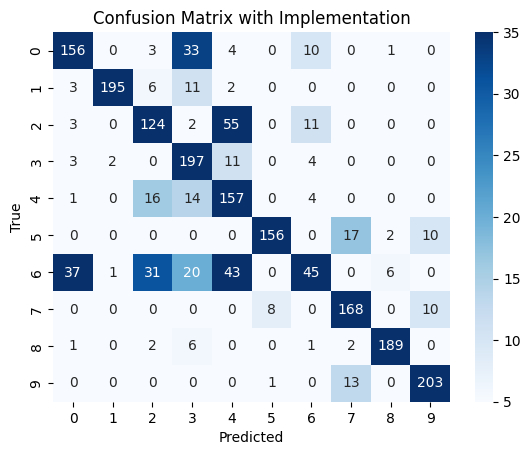

Precision (Weighted): 0.799
Recall (Weighted): 0.795
F1-Score (Weighted): 0.786


In [9]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=5, vmax=35)

plt.title('Confusion Matrix with Implementation')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

precision_weighted = precision_score(y_test, rf_predictions, average='weighted')
recall_weighted = recall_score(y_test, rf_predictions, average='weighted')
f1_weighted = f1_score(y_test, rf_predictions, average='weighted')

print(f"Precision (Weighted): {precision_weighted:.3f}")
print(f"Recall (Weighted): {recall_weighted:.3f}")
print(f"F1-Score (Weighted): {f1_weighted:.3f}")
